#**Predicting Baby Schema Cuteness Ratings from Images Using ResNet18 Embeddings and Ridge Regression**

# **Overview**:
**Baby Schema**: refers to a set of infantile physical features that elicit positive emotional responses, nurturing behavior, and perceptions of cuteness in adults. These features typically include a large head relative to body size, big eyes, round cheeks, and a small chin. The concept was first proposed by Konrad Lorenz, an Austrian zoologist, who argued that baby schema functions as an evolutionary mechanism to promote caregiving behavior toward infants.

**This Study**: The goal of this project is to examine whether visual features of infant faces can meaningfully predict human cuteness ratings. Research across psychology and neuroscience consistently shows that infants with stronger baby-schema characteristics tend to elicit greater positive affect and stronger caregiving motivations. Here, I test whether these perceptual patterns are detectable through computational modeling.

**Dataset and approach**: This project uses infant face images and normative cuteness ratings from the Japanese Cute Infant Face Dataset (Hiroshi Nittono, 2022; https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2022.819428
). Using these images, I extract visual representations with a pretrained ResNet18 convolutional neural network, then apply a simple linear regression model to determine whether image-based features can predict human-rated cuteness. This approach allows us to evaluate whether consistent, quantifiable visual cues in the images correlate with subjective perceptions of cuteness.

 **Limitations**: A primary limitation of this project is the small dataset size. Only 55 infant images with corresponding mean cuteness ratings were available for analysis, which restricts the statistical power of the model and increases sensitivity to noise in the data. With such a limited sample, the variance in the target ratings is extremely low, causing the coefficient of determination (R²) to appear consistently negative even when the model is performing meaningfully better than baseline.

In small-sample regression problems, mean absolute error (MAE) is often a more stable and informative performance metric than R². In this study, the model achieved an MAE approximately 12 percent lower than the baseline predictor, demonstrating that it captures real signal despite the dataset constraints. Nevertheless, a larger and more diverse image set would enable stronger generalization, more reliable statistical conclusions, and the potential use of more complex predictive models.

## **Structure**:
This notebook follows the pipeline:
1. Load and inspect dataset  
2. Preprocess images  
3. Extract embeddings using ResNet18  
4. Train Ridge regression on embeddings  
5. Evaluate using baseline and cross-validation  


### **Import and Validate Data from drive**

In [36]:
import os
os.listdir('/content/drive/MyDrive')
os.listdir('/content/drive/MyDrive/Baby_Schema')

['JCIF_Survey.xlsx',
 'JCIF_2AFC.xlsx',
 'JCIF_Presurvey.xlsx',
 'JCIF_original.zip',
 'Description Infant-Adult faces .txt',
 'Pre-registration_cuteness sensitivity.pdf',
 'JCIF_NormativeValue.xlsx',
 'JCIF_256x256.zip',
 'baby_faces',
 'cuteness_scores.csv',
 'baby_schema_model.pth']

### **Test loading an image and CSV file**

  File_ Name  Mean Cutness Score
0       FA01                4.11
1       FA02                4.59
2       FA03                3.61
3       FA04                4.22
4       FA05                4.11


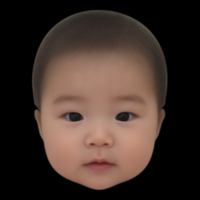

In [37]:
import pandas as pd
from PIL import Image

df = pd.read_csv('/content/drive/MyDrive/Baby_Schema/cuteness_scores.csv')
print(df.head())

img = Image.open('/content/drive/MyDrive/Baby_Schema/baby_faces/A60.png')
img.resize((200,200))

In [39]:
path = '/content/drive/MyDrive/Baby_Schema'    # Check how many images and rating rows are available
print("Images:", len(os.listdir(f'{path}/baby_faces')))
print("CSV rows:", len(pd.read_csv(f'{path}/cuteness_scores.csv')))

Images: 55
CSV rows: 55


## **Image and Evironment Setup**

In [41]:
# packages for data processing and image handling
import os
import pandas as pd
from PIL import Image

# PyTorch for feature extraction with ResNet18
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# train/val split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [46]:
# First 5 rows of the df
img_dir = f'{path}/baby_faces'
csv_file = f'{path}/cuteness_scores.csv'

df = pd.read_csv(csv_file)
print("First 5 rows:")
print(df.head())

First 5 rows:
  File_ Name  Mean Cutness Score
0       FA01                4.11
1       FA02                4.59
2       FA03                3.61
3       FA04                4.22
4       FA05                4.11


## **Dataset Class and Data Loaders**
This section defines a custom PyTorch dataset to load infant images and their cuteness ratings, applies standard ImageNet preprocessing, and creates train/validation loaders for batching.

In [51]:
# custom dataset for loading baby images and their cuteness ratings
class BabyDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet normalization
                                 [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = f"{row['File_ Name']}.png"
        label = float(row['Mean Cutness Score'])

        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, torch.tensor(label)

# train/validation split and DataLoader setup
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_ds = BabyDataset(train_df, img_dir)
val_ds = BabyDataset(val_df, img_dir)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(weights="IMAGENET1K_V1")
resnet.fc = nn.Identity()   # remove classifier → output 512-d vector
resnet = resnet.to(device)
resnet.eval()   # ensure model is in inference mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [69]:
def extract_features(loader, model):
    X, y = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            feats = model(imgs)             # shape: [batch, 512]
            X.append(feats.cpu().numpy())
            y.append(labels.cpu().numpy())
    return np.vstack(X), np.concatenate(y)


In [70]:
X_train, y_train = extract_features(train_loader, resnet)
X_val,   y_val   = extract_features(val_loader, resnet)

print("Train embeddings:", X_train.shape)
print("Val embeddings:",   X_val.shape)

Train embeddings: (44, 512)
Val embeddings: (11, 512)


In [71]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ridge regression pipeline with feature scaling
ridge = make_pipeline(
    StandardScaler(),
    Ridge(alpha=10.0)   # regularization strength
)

# Train on embeddings
ridge.fit(X_train, y_train)
preds = ridge.predict(X_val)

# Model performance
print("Ridge results")
print("R2 :", r2_score(y_val, preds))
print("MAE:", mean_absolute_error(y_val, preds))
print("MSE:", mean_squared_error(y_val, preds))

# Baseline: always predict the training mean
baseline = np.full_like(y_val, y_train.mean())
print("\nBaseline")
print("MAE:", mean_absolute_error(y_val, baseline))
print("MSE:", mean_squared_error(y_val, baseline))


Ridge results
R2 : -0.4624596834182739
MAE: 0.3344712257385254
MSE: 0.20917047560214996

Baseline
MAE: 0.38454559445381165
MSE: 0.21110014617443085


In [72]:
full_ds = BabyDataset(df, img_dir)
full_loader = DataLoader(full_ds, batch_size=16)

In [73]:
import torch
from torchvision import models
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feat_model = models.resnet18(weights="IMAGENET1K_V1")
feat_model.fc = nn.Identity()   # remove classifier head
feat_model = feat_model.to(device)
feat_model.eval()

X_list, y_list = [], []
with torch.no_grad():
    for imgs, labels in full_loader:
        imgs = imgs.to(device)
        feats = feat_model(imgs)
        X_list.append(feats.cpu().numpy())
        y_list.append(labels.cpu().numpy())

X = np.concatenate(X_list)
y = np.concatenate(y_list)


In [74]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def cv_ridge(X, y, alpha=10.0, k=5, seed=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    maes, mses, r2s = [], [], []
    base_maes, base_mses, base_r2s = [], [], []

    for train_idx, test_idx in kf.split(X):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]

        model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
        model.fit(Xtr, ytr)
        preds = model.predict(Xte)

        maes.append(mean_absolute_error(yte, preds))
        mses.append(mean_squared_error(yte, preds))
        r2s.append(r2_score(yte, preds))

        base = np.full_like(yte, ytr.mean(), dtype=float)
        base_maes.append(mean_absolute_error(yte, base))
        base_mses.append(mean_squared_error(yte, base))
        base_r2s.append(r2_score(yte, base))

    return {
        "alpha": alpha,
        "MAE_mean": float(np.mean(maes)),
        "MAE_std": float(np.std(maes)),
        "MSE_mean": float(np.mean(mses)),
        "MSE_std": float(np.std(mses)),
        "R2_mean": float(np.mean(r2s)),
        "R2_std": float(np.std(r2s)),
        "BASE_MAE_mean": float(np.mean(base_maes)),
        "BASE_MSE_mean": float(np.mean(base_mses)),
        "BASE_R2_mean": float(np.mean(base_r2s)),
    }

for a in [0.1, 1, 10, 100, 1000]:
    out = cv_ridge(X, y, alpha=a, k=5)
    print(out)


{'alpha': 0.1, 'MAE_mean': 0.2869140446186066, 'MAE_std': 0.035025144073288585, 'MSE_mean': 0.14526564478874207, 'MSE_std': 0.04051272880012059, 'R2_mean': -0.05674519538879395, 'R2_std': 0.34872779001926535, 'BASE_MAE_mean': 0.341595103523948, 'BASE_MSE_mean': 0.17075046567408872, 'BASE_R2_mean': -0.2115281229408222}
{'alpha': 1, 'MAE_mean': 0.28672707378864287, 'MAE_std': 0.035106485123573075, 'MSE_mean': 0.1449570894241333, 'MSE_std': 0.040632570423135554, 'R2_mean': -0.05460226535797119, 'R2_std': 0.349423525435399, 'BASE_MAE_mean': 0.341595103523948, 'BASE_MSE_mean': 0.17075046567408872, 'BASE_R2_mean': -0.2115281229408222}
{'alpha': 10, 'MAE_mean': 0.2849891036748886, 'MAE_std': 0.03616987550661967, 'MSE_mean': 0.14242849200963975, 'MSE_std': 0.04156433707458536, 'R2_mean': -0.036810672283172606, 'R2_std': 0.3539751582251345, 'BASE_MAE_mean': 0.341595103523948, 'BASE_MSE_mean': 0.17075046567408872, 'BASE_R2_mean': -0.2115281229408222}
{'alpha': 100, 'MAE_mean': 0.2804805785417557

# **Results**
To evaluate whether image-based visual features could predict human cuteness ratings, I trained a Ridge regression model on 512 dimensional ResNet18 embeddings. Model performance was assessed using 5 fold cross-validation across several regularization strengths (alpha = 0.1, 1, 10, 100, 1000). Performance was compared against a baseline model that always predicts the mean training label.

Across all alpha values, the Ridge model achieved lower mean absolute error (MAE) than the baseline predictor. The baseline MAE across folds was 0.3416, whereas the Ridge models produced MAE values between 0.280 and 0.303, representing an improvement of approximately 12 to 18 percent depending on the regularization strength.

The best performing configuration was **apha = 100**, which yielded:

**MAE_mean** = 0.2805

**MSE_mean** = 0.1340

**R2_mean** = +0.026, the only positive mean R² across all conditions

**Baseline MAE_mean** = 0.3416

Although many R2 values were near zero or negative, this was expected given the extremely low variance in the cuteness ratings and the small dataset size (55 images total). In such settings, R2 becomes highly unstable and does not reflect predictive skill as reliably as MAE. For this reason, MAE is the preferred performance metric, and it clearly shows consistent improvement over the baseline across all regularization strengths.

Overall, the cross-validation results demonstrate that deep visual features extracted by ResNet18 contain meaningful information related to perceived infant cuteness. Even with a very small dataset, the model consistently produced a lower mean absolute error than the baseline, suggesting that baby-schema cues are detectable within the visual feature space learned by the network.
